In [1]:
# various import statements
import os
import inspect
import seaborn
import matplotlib
import matplotlib.pyplot as plt
import torch
import scanpy as sc
import pyro
import cuml

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("GPU is available")
    print("Number of GPUs:", torch.cuda.device_count())
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available")
    
import random

import sys
import antipode
from antipode.antipode_model import *
import antipode.model_functions
from antipode.model_functions import *
import antipode.model_distributions
from antipode.model_distributions import *
import antipode.model_modules
from antipode.model_modules import *
import antipode.train_utils
from antipode.train_utils import *
import antipode.plotting
from antipode.plotting import *
from antipode.antipode_mixins import AntipodeTrainingMixin, AntipodeSaveLoadMixin


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPU is available
Number of GPUs: 1
GPU Name: NVIDIA A100-PCIE-40GB


In [2]:
model_tag='1.9.1.8.5_Retina_final_noQ_INP'
out_path=os.path.join('/home/matthew.schmitz/Matthew/models/',model_tag)
batch_key='batch'
discov_key='species'
layer_key='UMIs'


In [3]:
adata=sc.read_h5ad(os.path.expanduser('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/shekar_retina/retina_mammals_filtered.h5ad'),backed='r')
adata.uns['species_colors']=['blue','red','green','yellow','orange','cyan','magenta','teal','goldenrod','purple','maroon','pink','violet','black','grey','beige']

species_aggr_means=antipode.model_functions.group_aggr_anndata(adata,[discov_key],layer=layer_key,normalize=True)
species_real_means=torch.tensor(species_aggr_means[0],requires_grad=False)
species_log_real_means=safe_log_transform(species_aggr_means[0]) # #species,#cluster,#genes array

In [29]:
adata

AnnData object with n_obs × n_vars = 1156674 × 5172 backed at '/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/models/1.9.1.8.5_Retina_final_noQ_INP/p4_adata.h5ad'
    obs: 'file', 'species', 'batch', 'log10_n_counts', 'filter', '_scvi_discov_ind', '_scvi_batch_ind', 'psi_0', 'psi_1', 'psi_2', 'q_score', 'level_0', 'level_1', 'level_2', 'antipode_cluster', 'kmeans'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'log1p', 'param_store', 'species_colors', 'antipode_cluster_colors', 'level_0_colors', 'level_1_colors', 'level_2_colors', 'batch_colors'
    obsm: 'X_antipode', 'discov_onehot', 'kmeans_onehot', 'seccov_dummy', 'taxon_probs', 'X_antipode_UMAP'
    layers: 'UMIs'

In [5]:
num_var=adata.shape[1]
batch_size=32
level_sizes=[1,50,300]
num_latent=200
steps=0
max_steps=1000000
num_particles=3
print_every=5000

# Clear Pyro param store so we don't conflict with previous run
try:
    pyro.clear_param_store()
    del antipode_model
    torch.cuda.empty_cache()
except:
    pass
# Fix random number seed to a lucky number
pyro.util.set_rng_seed(13)
# Enable optional validation warnings
pyro.enable_validation(False)

# Instantiate instance of model/guide and various neural networks
antipode_model = ANTIPODE(num_latent=num_latent,level_sizes=level_sizes,bi_depth=2,num_batch_embed=10,psi_levels=[0.,1.,1.],
                adata=adata,discov_pair=('obs',discov_key),batch_pair=('obs',batch_key),layer=layer_key,min_theta=1e-1,
                use_psi=False,use_q_score=False,prior_scale=50.,theta_prior=10,sampler_category=discov_key,dist_normalize=False,dcd_prior=torch.tensor(species_log_real_means,requires_grad=False).float(),
                scale_init_val=0.01,loc_as_param=False,zdw_as_param=False,intercept_as_param=False,seccov_as_param=False)

In [6]:
antipode_model.run_standard_protocol(out_path,
                                     max_steps=max_steps,
                                     num_particles=num_particles,
                                     device=device,
                                     max_learning_rate=1e-3,
                                     one_cycle_lr=True,
                                     batch_size=batch_size)

In [8]:
# to reload the model
# adata = sc.read_h5ad(os.path.join('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/models',model_tag,'p4_adata.h5ad'),backed='r')
# antipode_model=ANTIPODE.load(os.path.join('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/models',model_tag),adata=adata,prefix='p3_',device=device)
# adata=antipode_model.adata_manager.adata
# antipode_model.store_outputs(device=device,prefix='')

In [10]:
!nvidia-smi
antipode_model.clear_cuda()
!nvidia-smi

Sat Feb  8 11:18:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-PCIE-40GB          Off |   00000000:CA:00.0 Off |                    0 |
| N/A   41C    P0             38W /  250W |    5681MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [11]:
MDE_KEY = "X_antipode_UMAP"
umap = cuml.UMAP(n_neighbors = 60,min_dist=0.2,spread=1,metric='manhattan',)
adata.obsm[MDE_KEY] = clip_latent_dimensions(umap.fit_transform(adata.obsm['X_antipode']),0.1)


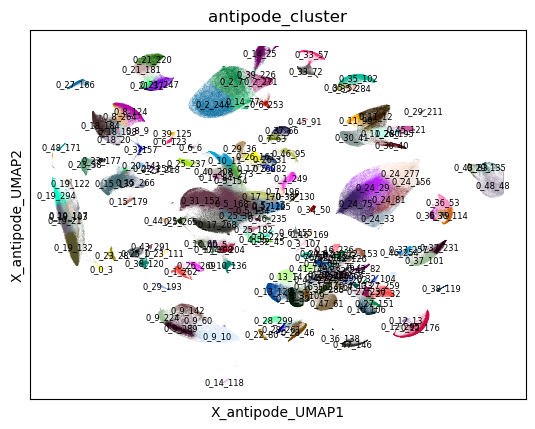

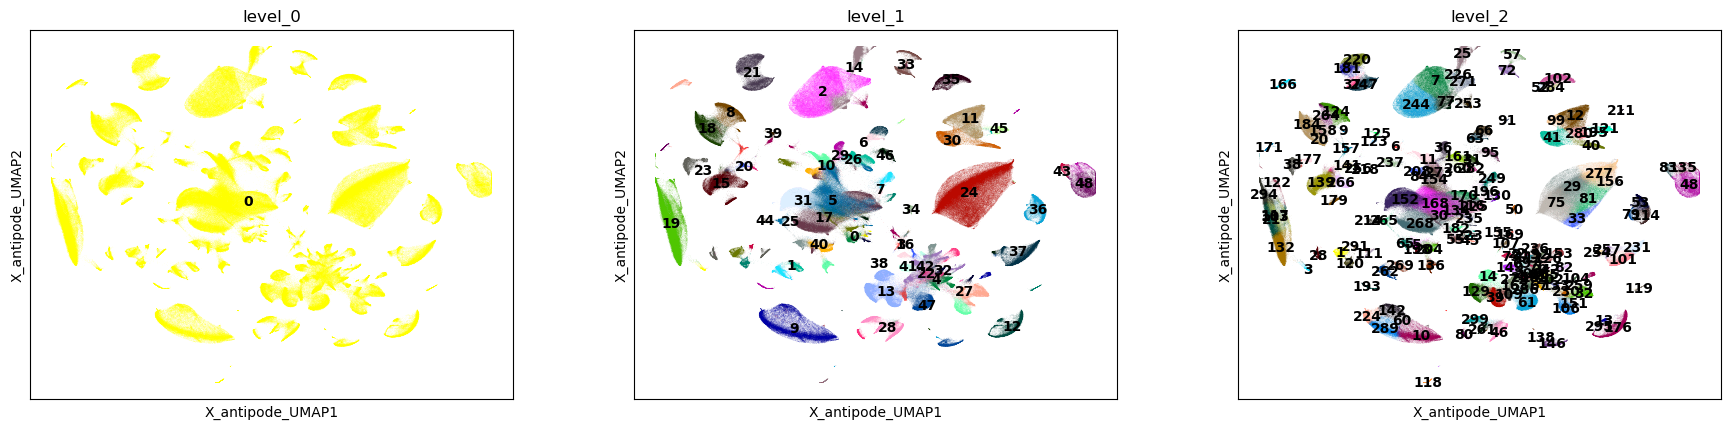

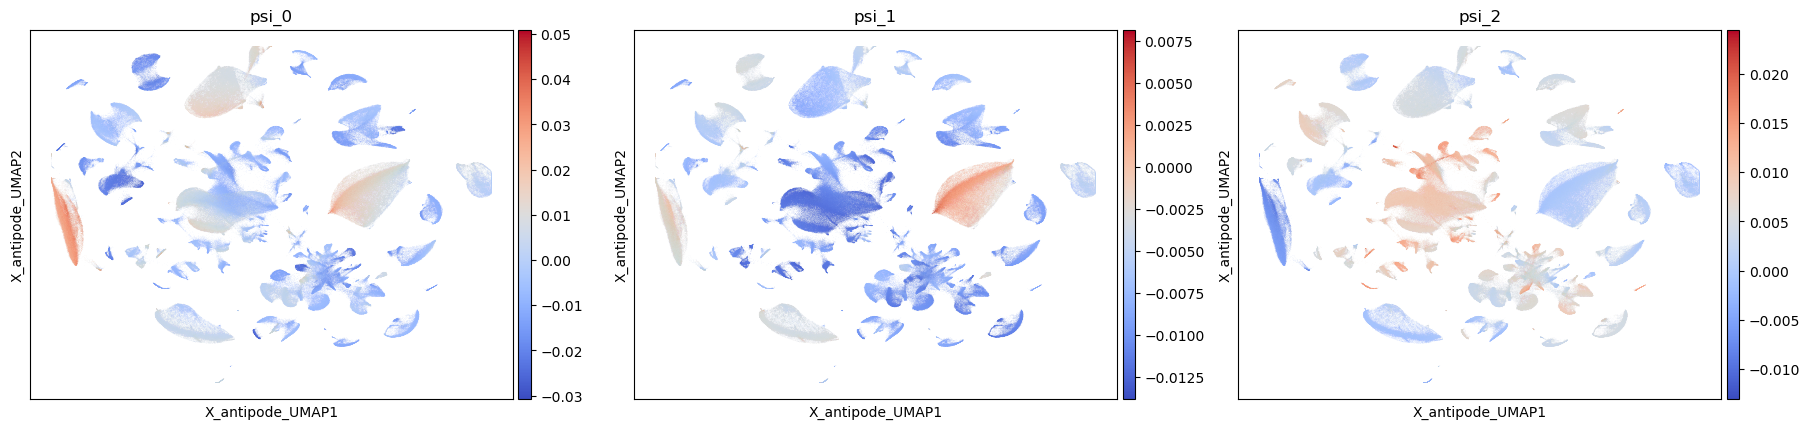

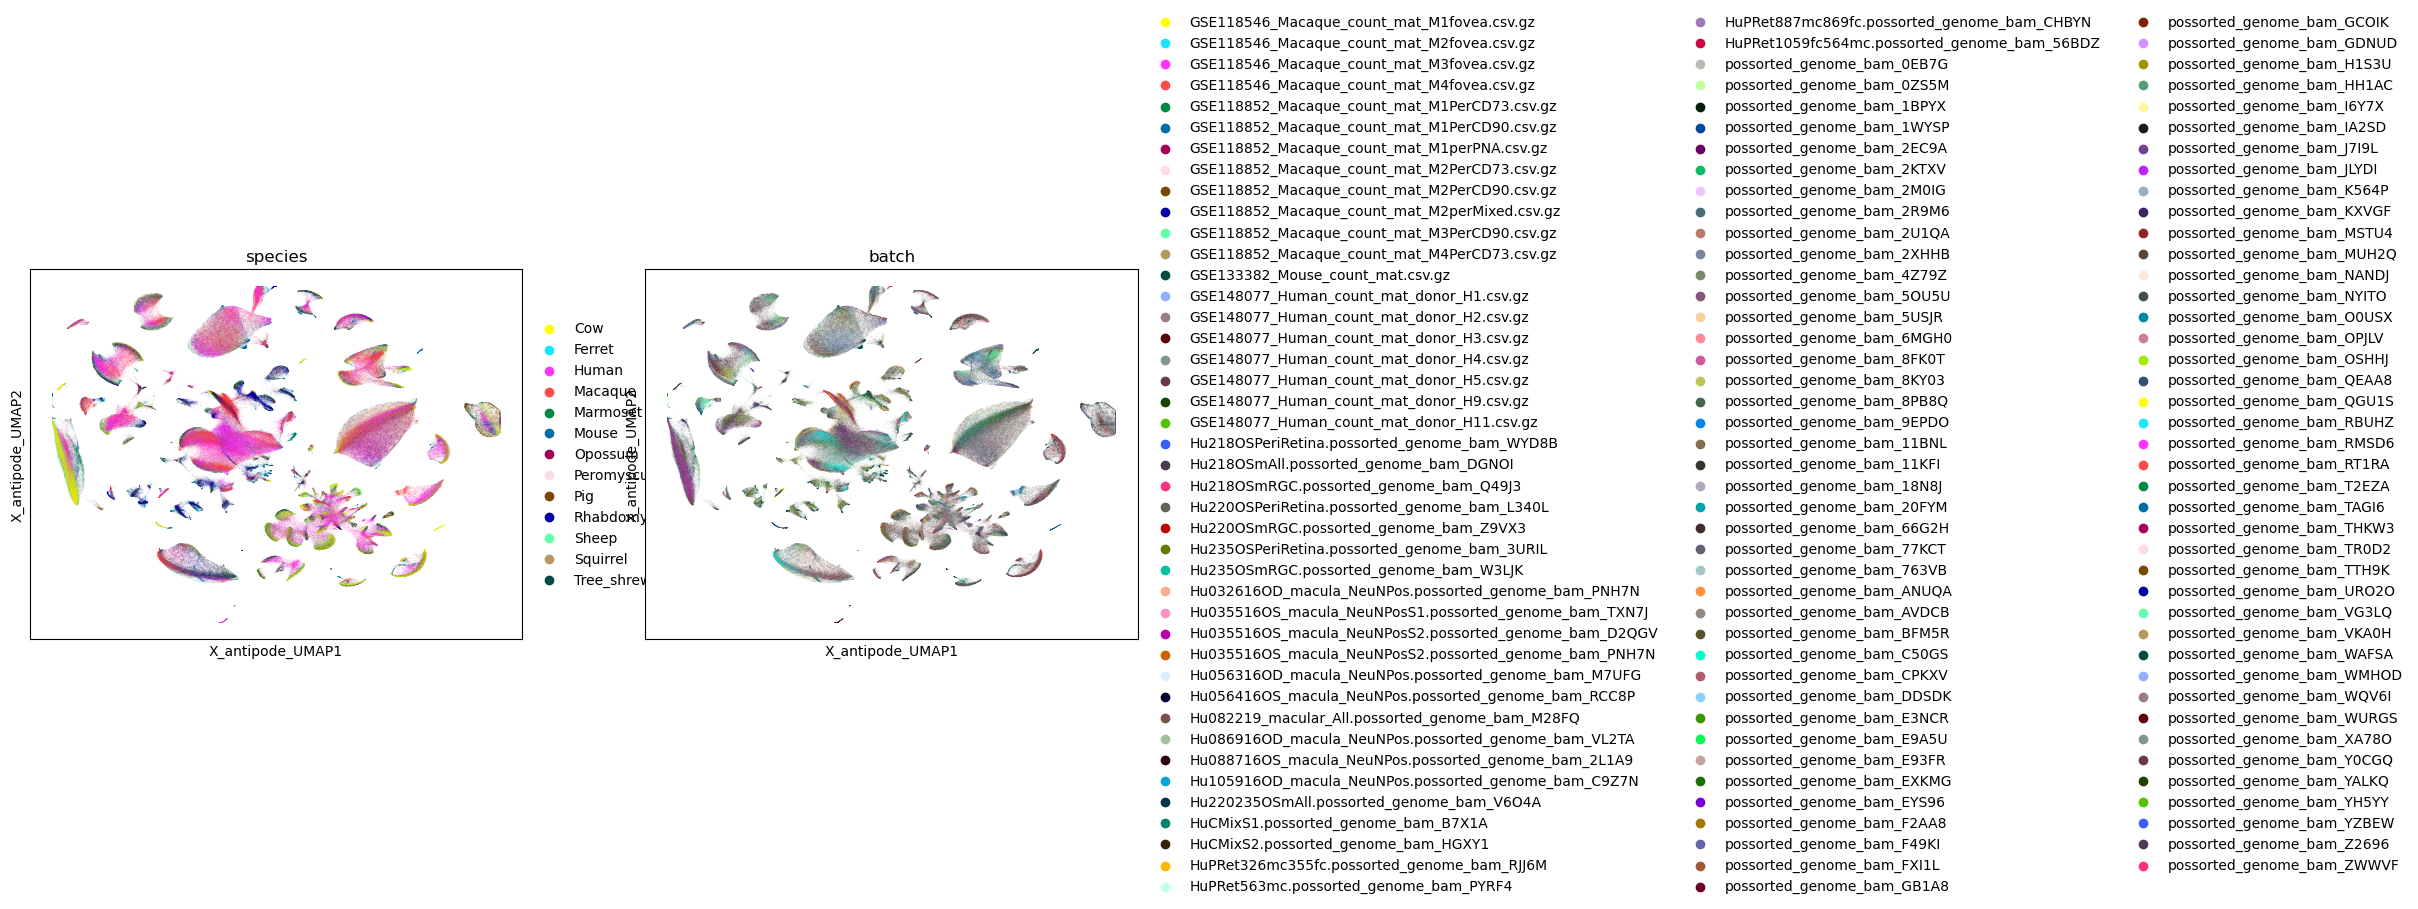

In [12]:
sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=["antipode_cluster"],legend_fontsize=6,legend_fontweight='normal',#,"kmeans"
    legend_loc='on data',palette=sc.pl.palettes.godsnot_102
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=[x for x in adata.obs.columns if 'level' in x],
    palette=sc.pl.palettes.godsnot_102,
    legend_loc='on data'
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=[x for x in adata.obs.columns if 'psi' in x],
    cmap='coolwarm',
    legend_loc='on data'
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    palette=sc.pl.palettes.godsnot_102,
    color=[discov_key,batch_key]
)

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


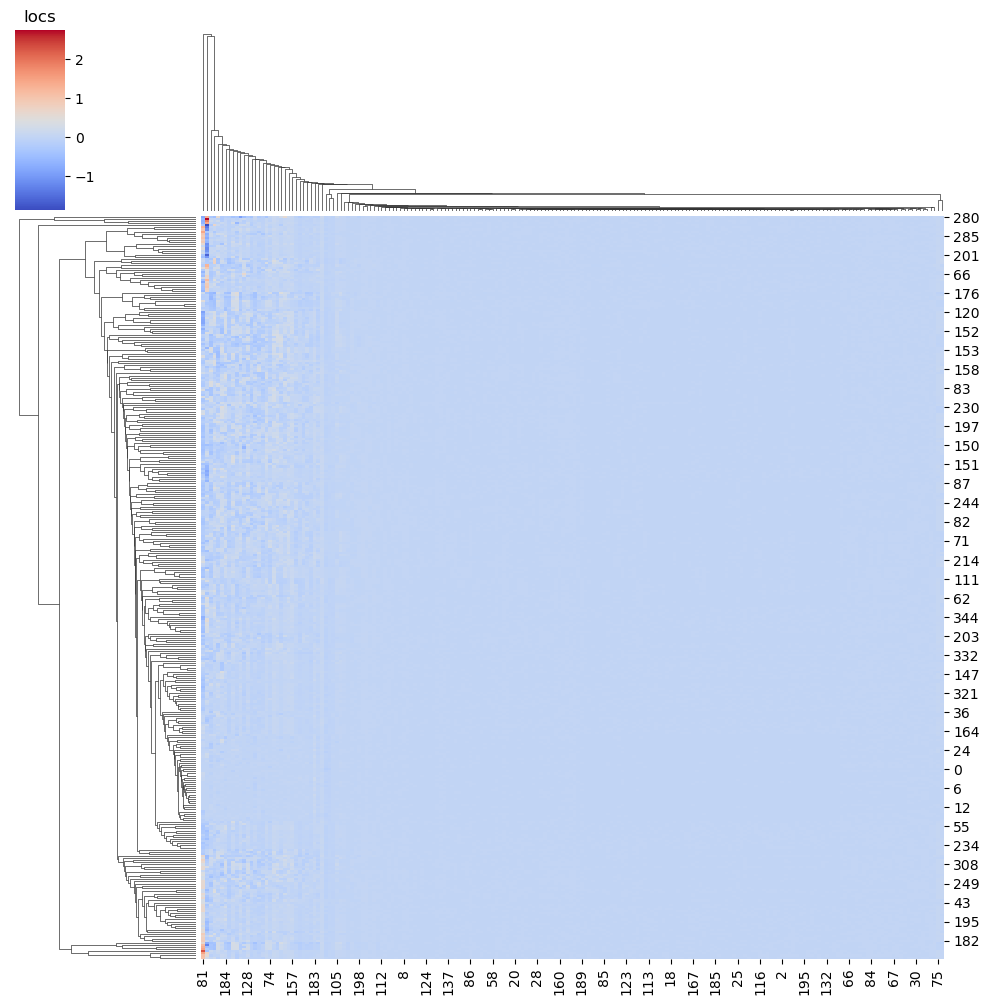

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


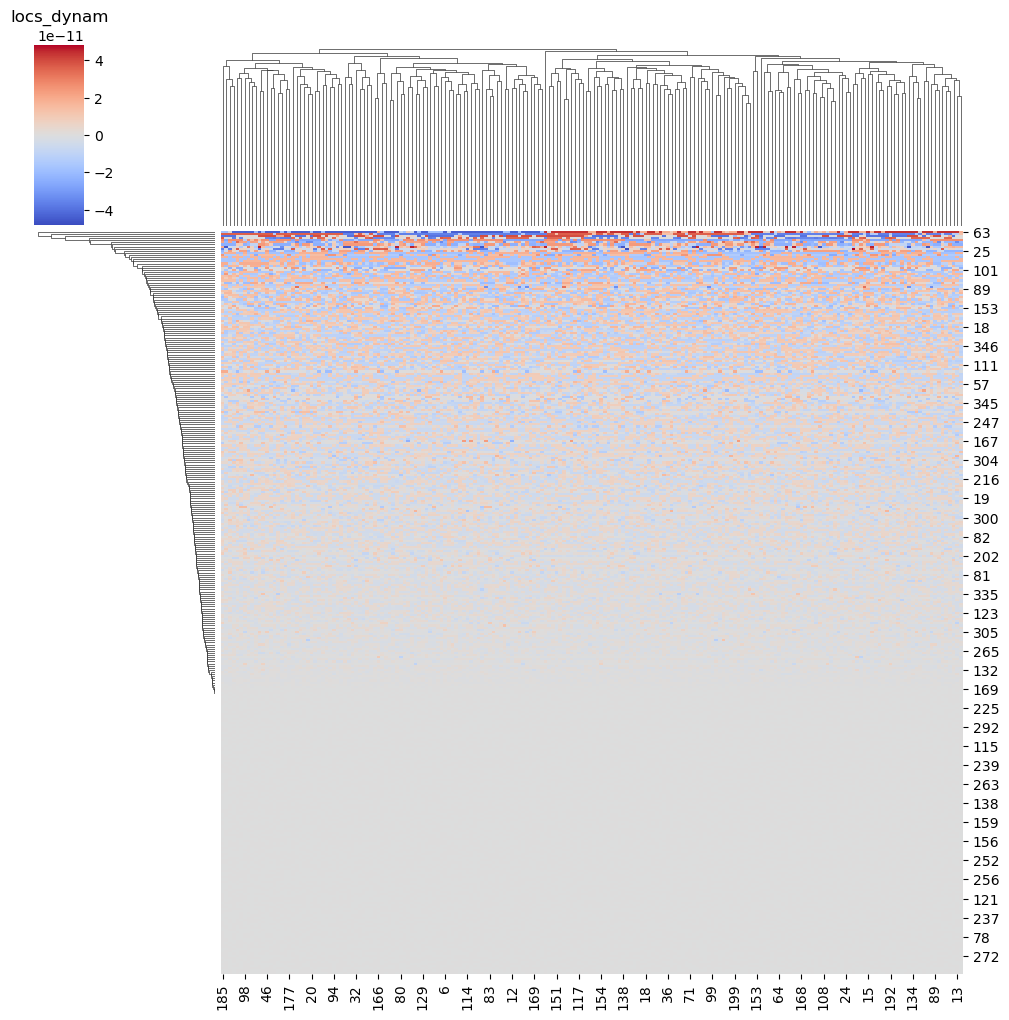

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


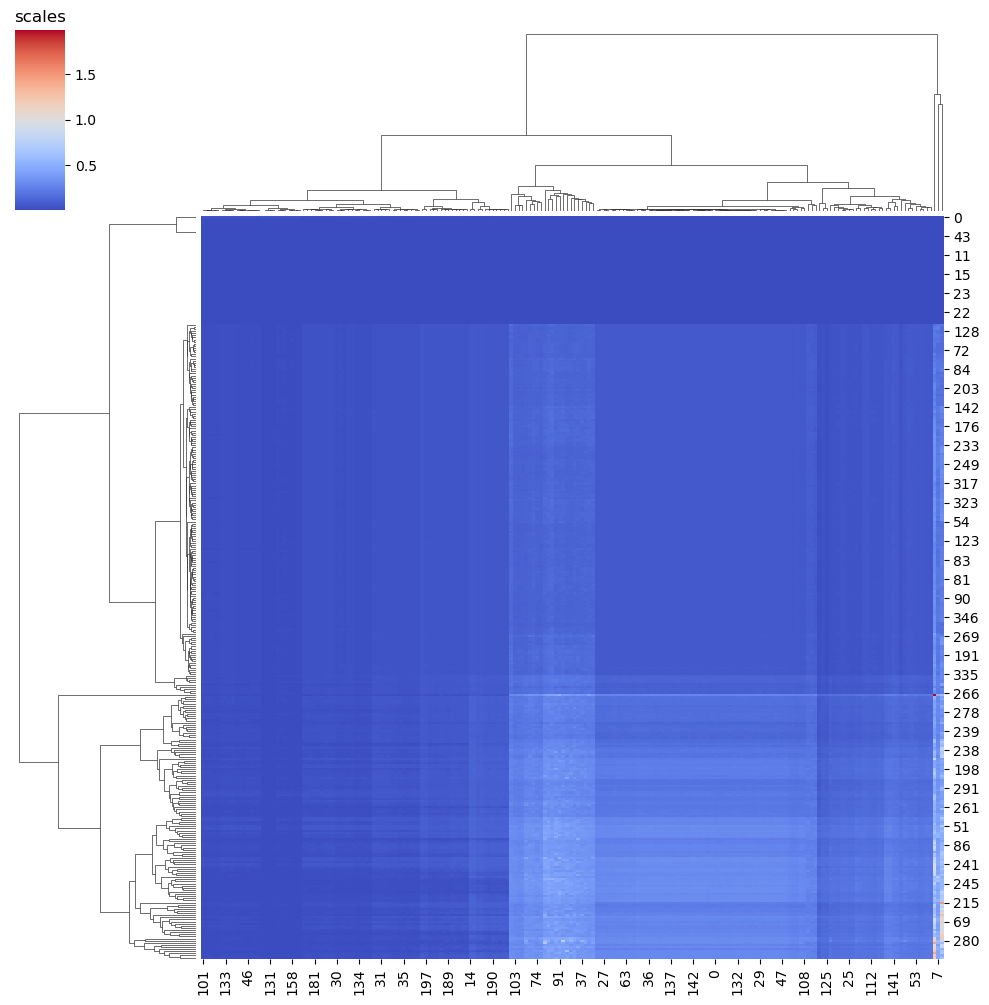

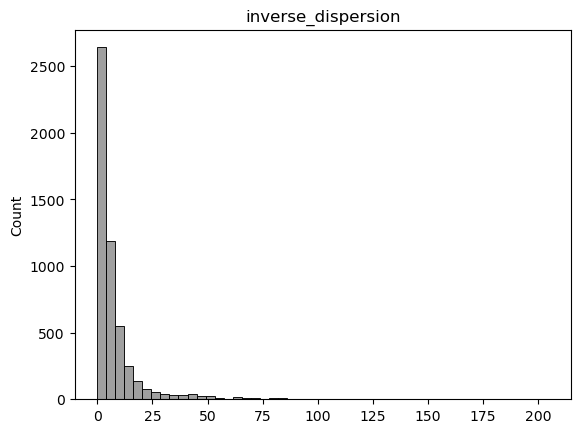

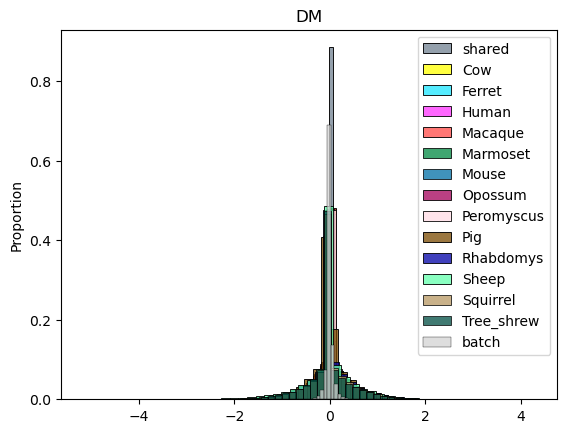

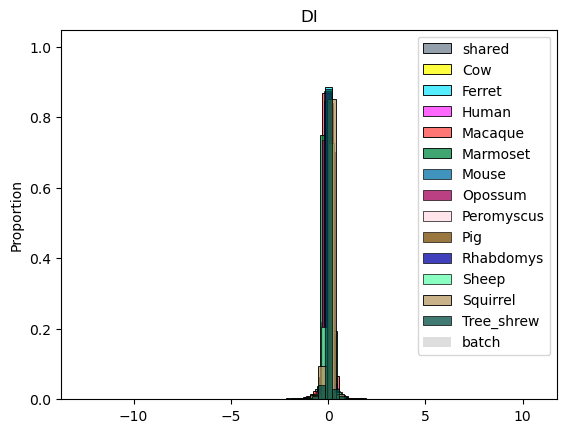

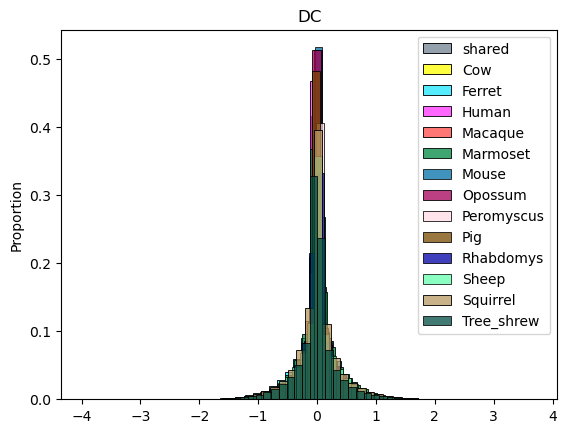

/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/code/scANTIPODE/antipode/plotting.py:77: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_species=antipode_model.adata_manager.adata.obs.groupby(antipode_model.batch_key)['species'].value_counts().unstack().idxmax(axis=1).to_dict()


,0,1,batch,species
0,0.000008,0.000002,GSE118546_Macaque_count_mat_M1fovea.csv.gz,Macaque
1,0.000008,0.000002,GSE118546_Macaque_count_mat_M2fovea.csv.gz,Macaque
2,0.000008,0.000002,GSE118546_Macaque_count_mat_M3fovea.csv.gz,Macaque
3,0.000006,0.000002,GSE118546_Macaque_count_mat_M4fovea.csv.gz,Macaque
4,0.000010,0.000006,GSE118852_Macaque_count_mat_M1PerCD73.csv.gz,Macaque
...,...,...,...,...
120,-0.000013,0.000005,possorted_genome_bam_YALKQ,Sheep
121,-0.000013,0.000006,possorted_genome_bam_YH5YY,Tree_shrew
122,0.000012,-0.000003,possorted_genome_bam_YZBEW,Sheep
123,0.000008,0.000002,possorted_genome_bam_Z2696,Sheep


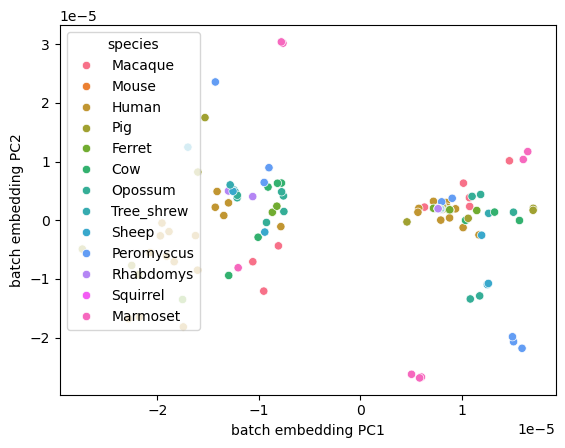

In [14]:
plot_loss(antipode_model.losses)
plot_gmm_heatmaps(antipode_model)
plot_d_hists(antipode_model)
plot_batch_embedding_pca(antipode_model)

In [16]:
pstore=adata.uns['param_store']
discov_cluster_params,cluster_params, cluster_labels,var_labels,(prop_taxon, prop_locs,prop_discov_di,prop_discov_dm)=antipode_model.calculate_cluster_params(flavor='numpy')
cluster_index = np.array([int(x) for x in cluster_labels])
discov_cluster_params = discov_cluster_params[:,cluster_index,:]
discov_labels=adata.obs[antipode_model.discov_key].cat.categories
latent_labels=[str(x) for x in range(pstore['discov_dc'].shape[1])]
n_clusters=antipode_model.level_sizes[-1]

In [17]:
aggr_means=antipode.model_functions.group_aggr_anndata(adata,[discov_key,'level_2'],layer=layer_key,normalize=True)
log_real_means=antipode.model_functions.safe_log_transform(aggr_means[0]) # #species,#cluster,#genes array

100%|██████████| 2184/2184 [00:37<00:00, 58.75it/s] 


In [18]:
real_means=pd.DataFrame(log_real_means.mean(0),columns=adata.var.index,index=aggr_means[1]['level_2'])
real_means=real_means.loc[aggr_means[1]['level_2'],:]

In [21]:
fits=[]
for i in range(discov_cluster_params.shape[0]):
    for g in range(discov_cluster_params.shape[2]):
        x=discov_cluster_params[i,:,g]
        y=log_real_means[i,:,g]
        fits.append(scipy.stats.stats.spearmanr(x,y).statistic)


/scratch/fast/4841/ipykernel_4056628/2048301033.py:6: DeprecationWarning: Please import `spearmanr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  fits.append(scipy.stats.stats.spearmanr(x,y).statistic)
/scratch/fast/4841/ipykernel_4056628/2048301033.py:6: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  fits.append(scipy.stats.stats.spearmanr(x,y).statistic)


0.7697000109781258


Text(0.5, 1.0, '')

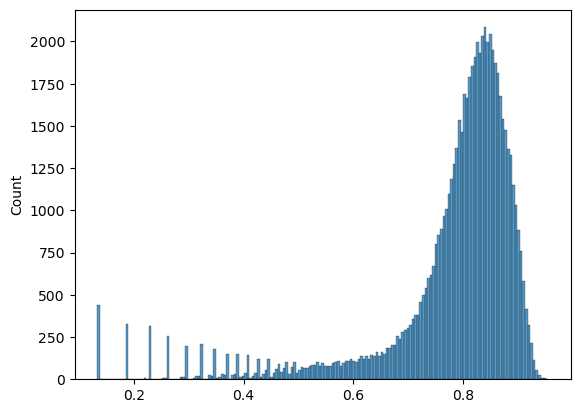

In [22]:
print(np.mean(np.nan_to_num(fits)))
seaborn.histplot(fits)
plt.title('')

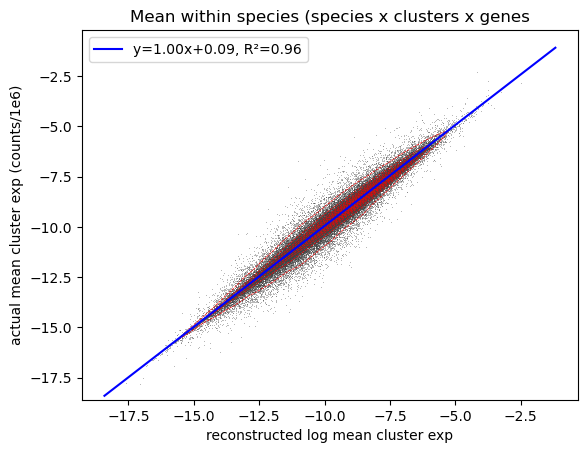

In [28]:
# Calculate the regression parameters
x=(discov_cluster_params).flatten()
x=safe_log_transform(np.exp(x))
y=log_real_means.flatten()
zeros=y>-18
x=x[zeros]
y=y[zeros]
randinds=np.random.choice(np.array(list(range(x.shape[0]))),size=100000,replace=False)


seaborn.scatterplot(x=x[randinds],y=y[randinds],s=0.2,color='black')
seaborn.kdeplot(x=x[randinds],y=y[randinds],linestyles='--',color='red', linewidths=0.5)
plt.xlabel('reconstructed log mean cluster exp')
plt.ylabel('actual mean cluster exp (counts/1e6)')


slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)

# Plot the regression line
x_values = np.linspace(np.min(x), np.max(x), 100)
plt.plot(x_values, slope * x_values + intercept, color='blue', label=f'y={slope:.2f}x+{intercept:.2f}, R²={r_value**2:.2f}')
plt.title('Mean within species (species x clusters x genes')
# Add legend
plt.legend()

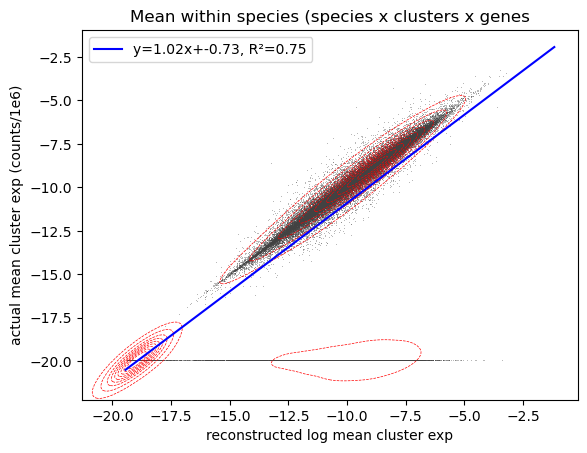

In [26]:
# 
# Calculate the regression parameters
x=(discov_cluster_params).flatten()
x=safe_log_transform(np.exp(x))
y=log_real_means.flatten()
randinds=np.random.choice(np.array(list(range(x.shape[0]))),size=100000,replace=False)


seaborn.scatterplot(x=x[randinds],y=y[randinds],s=0.2,color='black')
seaborn.kdeplot(x=x[randinds],y=y[randinds],linestyles='--',color='red', linewidths=0.5)
plt.xlabel('reconstructed log mean cluster exp')
plt.ylabel('actual mean cluster exp (counts/1e6)')


slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)

# Plot the regression line
x_values = np.linspace(np.min(x), np.max(x), 100)
plt.plot(x_values, slope * x_values + intercept, color='blue', label=f'y={slope:.2f}x+{intercept:.2f}, R²={r_value**2:.2f}')
plt.title('Mean within species (species x clusters x genes')
# Add legend
plt.legend()

In [27]:
antipode_model.save(os.path.join('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/models',model_tag),save_anndata=True,prefix='p4_')